In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/social-media-user-activity-dataset/instagram_usage_lifestyle.csv


In [2]:
#Preprocessing data 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

social_data = pd.read_csv('/kaggle/input/social-media-user-activity-dataset/instagram_usage_lifestyle.csv')
X = social_data.copy()
y = X.pop('self_reported_happiness')

features_cat = ['gender', 'country', 'income_level', 'employment_status',
           'education_level', 'alcohol_frequency','has_children', 'uses_premium_features'
               ]
features_num = ['age','hobbies_count', 'body_mass_index',
               'average_session_length_minutes', 'time_on_reels_per_day', 'time_on_explore_per_day', 
               'social_events_per_month']

trans_cat = make_pipeline(
    SimpleImputer(strategy = 'constant', fill_value = 'NA'),
    OneHotEncoder(handle_unknown = 'ignore')
)
trans_num = make_pipeline(
    SimpleImputer(strategy = 'constant'),
    StandardScaler(),
)

preprocessor = make_column_transformer(
    (trans_num, features_num),
    (trans_cat, features_cat),
)

#Splitting data
X_train, X_valid, y_train, y_valid= train_test_split(X, y, train_size =0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]
print(X.shape)

(1547896, 57)


In [3]:
print(type(X_train))
print(type(X_valid))
print(y_train.dtypes)
print(y_valid.dtypes)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
int64
int64


In [4]:
import matplotlib as plt 
plt.style.use('seaborn-v0_8-whitegrid')

plt.rc('figure', autolayout = True)
plt.rc('axes', labelweight = 'bold', labelsize = 'large',
      titleweight = 'bold', titlesize =18, titlepad =10)
plt.rc('animation', html = 'html5')
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


2026-02-05 19:20:46.997006: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770319247.257488      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770319247.326186      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770319247.923534      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770319247.923574      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770319247.923577      17 computation_placer.cc:177] computation placer alr

<Axes: >

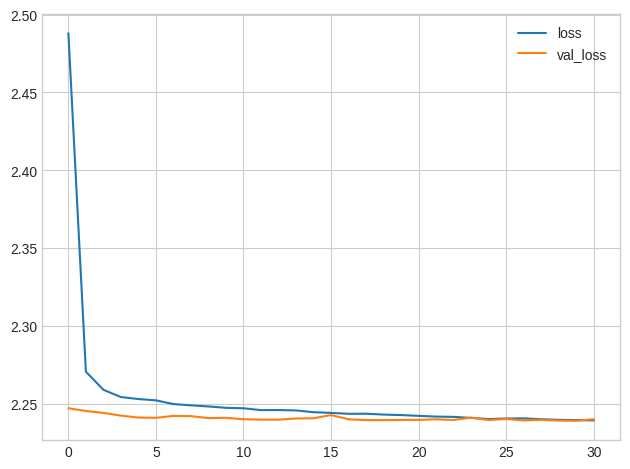

In [5]:
from tensorflow import keras 
from tensorflow.keras import layers
from keras.src.callbacks import EarlyStopping

model = keras.Sequential([
    layers.Dense(120, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
     layers.Dense(120, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1),
])

model.compile(
    optimizer = 'adam', 
    loss = 'mae',
)
early_stopping = keras.callbacks.EarlyStopping(
    patience =20,
    min_delta =0.001,
    restore_best_weights = True,
)

history = model.fit(
    X_train, y_train, 
    validation_data = (X_valid, y_valid),
    batch_size = 512, 
    epochs = 1000,
    callbacks = [early_stopping],
    verbose = 0,
)

history_graph = pd.DataFrame(history.history)
history_graph.loc[:, ['loss', 'val_loss']].plot()

In [6]:
from sklearn.metrics import mean_absolute_error
preds = model.predict(X_valid)
print(mean_absolute_error(y_valid, preds))

print(preds[:5])

12093/12093 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step
2.239896774291992
[[5.5001354]
 [7.246981 ]
 [4.203741 ]
 [7.578669 ]
 [2.8546877]]


In [7]:
from sklearn.metrics import mean_absolute_error

base_mae = mean_absolute_error(
    y_valid, 
    np.full_like(y_valid, y_train.mean())
)
print(base_mae)

2.5005969393292573
